# Imports

In [4]:
import pandas as pd
import numpy as np
import random
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity
from scipy import spatial
from sklearn.cluster import KMeans, AgglomerativeClustering

from sklearn.preprocessing import PolynomialFeatures, Normalizer, MinMaxScaler

#from flakylib import *
#from numba import njit, prange

from rouge import Rouge 

from tqdm.notebook import tqdm
import pickle
import gc
import time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

#from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.preprocessing import normalize

In [13]:
from rouge import Rouge 

hypothesis = "the #### transcript is a written version of each day 's cnn student news program use this transcript to he    lp students with reading comprehension and vocabulary use the weekly newsquiz to test your knowledge of storie s you     saw on cnn student news"
reference = "this page includes the show transcript use the transcript to help students with reading comprehension and     vocabulary at the bottom of the page , comment for a chance to be mentioned on cnn student news . you must be a teac    her or a student age # # or older to request a mention on the cnn student news roll call . the weekly newsquiz tests     students ' knowledge of even ts in the news"

#rouge metric based on https://pypi.org/project/rouge/
def my_rouge2(hypothesis, reference):
    rouge = Rouge()
    scores = rouge.get_scores(hypothesis, reference)
    
    #rouge-1
    r1_f1=scores[0]['rouge-1']['f']
    r1_precision=scores[0]['rouge-1']['p']
    r1_recall=scores[0]['rouge-1']['r']
    
    #rouge-2
    r2_f1=scores[0]['rouge-2']['f']
    r2_precision=scores[0]['rouge-2']['p']
    r2_recall=scores[0]['rouge-2']['r']
    
    return r1_f1, r2_f1, #, precision, recall

my_rouge2(hypothesis, reference)

(0.4786324739396596, 0.2608695605353498)

In [5]:
def save_obj(obj, name):
    pickle.dump(obj,open(name + '.pkl', 'wb'), protocol=4)
    
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

# Load Dataset

In [62]:
df = load_obj('ds_bs_rouge')
df.head()

,article_id,article_text,abstract_text,labels,section_names,sections,len_text,len_abstract,sent_ext,word_ext,word_inf,best_rouge1_wih,best_rouge2_wih,best_summary_wih
0,astro-ph0202198,[the study of supernovae ( sne ) has greatly a...,[large numbers of supernovae ( sne ) have been...,NaN,"[introduction, method, results, future prospec...",[[the study of supernovae ( sne ) has greatly ...,341,12,0.000000,0.897436,0.076004,0.484935,0.146763,"[once discovered , the study of a particular s..."
1,0905.2691,[it is believed that solar magnetic fields are...,[we investigate the emergence of magnetic flux...,NaN,"[introduction, observations and data reduction...",[[it is believed that solar magnetic fields ar...,329,11,0.000000,0.884892,0.073258,0.629482,0.296000,[they move upward and emerge into the solar at...
2,1305.7010,[the origin - destination ( od ) matrix is imp...,[the estimation of the number of passengers wi...,NaN,"[introduction, the passenger model, the observ...",[[the origin - destination ( od ) matrix is im...,225,10,0.000000,0.740157,0.074367,0.454395,0.123128,[+ when the information is not available ( for...
3,1402.0371,[multiscale dynamics is present in many phenom...,[the classical structure - function ( sf ) met...,NaN,"[introduction, detrending analysis and detrend...",[[multiscale dynamics is present in many pheno...,216,15,0.066667,0.949045,0.171659,0.767442,0.556667,[a detrended structure - function ( dsf ) meth...
4,1701.00774,[the @xmath3-transformation has been extensive...,"[given a real number @xmath0 , we study the as...",NaN,"[introduction, coded negative beta-shift, lap ...",[[the @xmath3-transformation has been extensiv...,353,11,0.000000,0.867925,0.059547,0.541176,0.236407,"[thus , the previous proposition allows us to ..."


In [63]:
df.shape

(17343, 14)

# Calculating best possible rouge summary

For each text going over random combinations of sentences 
$C\binom ad$
where, **a** - is the number of sentences in the abstract, and **d** - is the number of sentences in the respective document,
and calculating it's ROUGE score against the available golden summary. The process is repeated in 2 variants - with and without VNS. Then keep the best obtained summary.

In [6]:
#VNS to find best rouge available


def vns_best_sum(text, abstract):
    #initial random summary
    d=len(text)
    a=len(abstract)
    g_sum='. '.join(abstract)
    
    sent_sample=random.sample(range(d), a)
    
    best_sum='. '.join([text[i] for i in sent_sample])
    
    #calculate rouge
    best_objective=my_rouge2(best_sum,g_sum)#

    #VNS
    k_max=3
    max_cpu_time=60
    max_iterations=10000
    ni_lim=700 #no improvement iterations limit

    k = 1
    n_iters = 0 # Инициализируем счётчик итераций
    ni=0
    start_time = time.perf_counter() # Фиксcurrent_time = time.perf_counter()
    cpu_time = 0

    while (cpu_time < max_cpu_time) and (n_iters < max_iterations):#(cpu_time < max_cpu_time) and 
        s=sent_sample
        #select random indices to change in initial solution
        ind_change = random.sample(range(len(s)), k)
        #delete indexes to change
        s=[s[i] for i in range(a) if i not in ind_change]

        #generate new indices and add them to the summary sentence list
        while len(s)<a+k:
            j=random.randint(0,d-1)
            if j not in s:
                s.append(j)
        
        #generate new summary 
        neighbourhood='. '.join([text[i] for i in s])
        objective=my_rouge2(neighbourhood, g_sum)
        #print('nq_metric', nq_metric, 'q_metric', q_metric)
        if objective>best_objective:
            best_sum=neighbourhood
            best_objective=objective
            sent_sample=s
            #print(best_objective,k,n_iters, ni)
            k=1
        else:
            if k<k_max:
                k+=1
            ni+=1
            
        #update the counters
        cpu_time = time.perf_counter() - start_time
        n_iters+=1
        
        if ni==ni_lim:
            print('No ROUGE-1 improvement on more than 700 iterations. Exit.')
            break
    
    #get the final summary rouge score
    sent_sample.sort()
    #print(sent_sample)
    final_summary=[text[i] for i in sent_sample]
    is_sum_sent=[1 if s in final_summary else 0 for s in text]
    r=my_rouge2('. '.join(final_summary), g_sum)
    #print('n_iters',n_iters)
    return r, final_summary, is_sum_sent

In [7]:
text=df.article_text.iloc[0]
abstract=df.abstract_text.iloc[0]
r,s, issumsent=vns_best_sum(text, abstract)
print(r,s)

0.5133333283360556 ['1996 ; treffers et al .', 'once discovered , the study of a particular sn , and its use as a tool for any of the applications above , is almost always based on spectroscopic verification and classification .', 'the information extracted from sn spectra usually includes ( but is not limited to ) the sn type , redshift , and age ( relative to the dates of explosion or peak brightness ) .', '2001b ; see also @xmath18 ) .', 'the obvious alternative for spectroscopy is multi - color broadband photometry .', 'while dg2002 seek only to identify high-@xmath12 sne  ia detected by a particular observational setup , we present general methods that apply to all the major sn subtypes and can be used for a wide range of sn surveys , including searches that are similar to those described by dg2002 .', 'the sn type can be securely determined only from observations of the active sn itself .', 'the sn classification scheme we adopt needs , therefore , to rely only on spectral proper

In [14]:
import os.path
#prepare the data for classification

def create_classif_data(texts, abstracts, ids, c):
    if os.path.isfile('./_vns_tmp/X_vns'+str(c)+'.pkl'):
        X_sent=load_obj('./_vns_tmp/X_vns'+str(c))
        Art_ID=load_obj('./_vns_tmp/Art_ID_vns'+str(c))
        Y=load_obj('./_vns_tmp/Y_vns'+str(c))
        best_rouges=load_obj('./_vns_tmp/best_rouges_vns'+str(c))
        best_sum=load_obj('./_vns_tmp/best_sum_vns'+str(c))
        start=len(best_rouges)
        print('Process restarting. Starting from',start)
    else:
        X_sent = []
        Y = []
        Art_ID = []
        best_rouges = []
        best_sum = []
        start=0
    #art_num=100
    cnt_save=0
    
    for t, a, a_ids in zip(tqdm(texts[start:]), abstracts[start:], ids[start:]):
        #print(len(t), len(a))
        if len(t)>len(a) and len(a)>=5:
            try:
                #print(1)
                r, s, issumsent=vns_best_sum(t, a)
                X_sent.append(t)
                Art_ID.append([a_ids for i in range(len(t))])
                Y.append(issumsent)
                best_rouges.append(r)
                
                cnt_save+=1
                
                #save results on the go
                if cnt_save%50==0:
                    print('Saving work', c, 'counter value', cnt_save)
                    save_obj(X_sent, './_vns_tmp/X_vns'+str(c))
                    save_obj(Y, './_vns_tmp/Y_vns'+str(c))
                    save_obj(Art_ID, './_vns_tmp/Art_ID_vns'+str(c))
                    save_obj(best_rouges, './_vns_tmp/best_rouges_vns'+str(c))
                    save_obj(best_sum, './_vns_tmp/best_sum_vns'+str(c))
            except:
                #print('Err')
                continue
        else:
            print('Number of sentences in article are smaller than in abstract OR abstract is shorter than 5 sentences')
    
    #final save
    save_obj(X_sent, './_vns_tmp/X_vns'+str(c))
    save_obj(Y, './_vns_tmp/Y_vns'+str(c))
    save_obj(Art_ID, './_vns_tmp/Art_ID_vns'+str(c))
    save_obj(best_rouges, './_vns_tmp/best_rouges_vns'+str(c))
    save_obj(best_sum, './_vns_tmp/best_sum_vns'+str(c))
            
       
    return X_sent, Y, Art_ID, best_rouges, best_sum

In [15]:
create_classif_data(df.article_text[0:3], df.abstract_text[0:3], df.article_id[0:3], 150)

No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.



([['the study of supernovae ( sne ) has greatly advanced in the last few years .',
   'intensive and highly automated monitoring of nearby galaxies ( e.g. , li et al .',
   '1996 ; treffers et al .',
   '1997 ; filippenko et al .',
   '2001 ; dimai 2001 ; qiu & hu 2001 ) , wide - field , moderately deep surveys ( e.g. , reiss et al . 1998 ; gal - yam & maoz 1999 , 2002 ; hardin et al . 2000 ; schaefer 2000 ) , and cosmology - oriented , deep , high - redshift sn search projects ( perlmutter et al . 1997 ; schmidt et al .',
   '1998 ) now combine to yield hundreds of new sn discoveries each year .',
   'ambitious programs that are currently planned or underway [ e.g. , the nearby supernova factory  aldering et al .',
   '2001 ; the supernova / acceleration probe ( snap ) ',
   'perlmutter et al . 2000 ; automated sn detections in sloan digital sky survey ( sdss ) data  vanden berk et al .',
   '2001 ; miknaitis et al .',
   '2001b ; see also @xmath9 promise to increase these numbers by 

#### Parallelization

In [16]:
# I mostly borrow this code from http://blog.adeel.io/2016/11/06/parallelize-pandas-map-or-apply/
# https://github.com/rafaelvalero/ParallelTextProcessing/blob/master/parallelizing_text_processing.ipynb
import multiprocessing
import pandas as pd
import numpy as np
from multiprocessing import Pool
import scipy.sparse as sp
#num_partitions = 5
num_cores = multiprocessing.cpu_count()
num_partitions = num_cores-5 # I like to leave some cores for other
#processes
print(num_partitions)

27


In [17]:
def create_data(data,c):
    print("Process working on: "+str(c))
    #lem_text=[custom_lemm(t) for t in tqdm(data)]
    X, Y, idx, best_rouges, best_sum = create_classif_data(data.article_text, data.abstract_text, data.article_id, c)
    print("Process #%s finished" % c)
    return X, Y, idx, best_rouges, best_sum

In [18]:
def parallelize_data_cr(df, func):
    parts=[]
    a = np.array_split(df, num_partitions)
    #print(1)
    #del df
    pool = Pool(num_partitions)
    jobs = []
    #print(2)
    #x = pd.concat(pool.map(func, [a,b,c,d,e]))
    finished=[]
    for i in range(0, num_partitions):
        if i not in finished:
            jobs.append(pool.apply_async(func,(a[i],i)))
    #print(3)
    #x = sp.vstack(pool.map(func, [a,b,c,d,e,f]), format='csr')
    
    for job in jobs:
        parts.append(job.get())
    print(4)
    
    pool.close()
    
    pool.join()
    return parts

In [19]:
classif_data=parallelize_data_cr(df, create_data)


Process working on: 0


Process working on: 1


Process working on: 2


Process working on: 3


Process working on: 4


Process working on: 5


Process working on: 6


Process working on: 7


Process working on: 8


Process working on: 9


Process working on: 10


Process working on: 11


Process working on: 12


Process working on: 13


Process working on: 14


Process working on: 15


Process working on: 16


Process working on: 17


Process working on: 18


Process working on: 19


Process working on: 20


Process working on: 21


Process working on: 22


Process working on: 23


Process working on: 24


Process working on: 25


Process working on: 26


No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 imp

No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 imp

No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 imp

No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 imp

No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 imp

No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 imp

No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 imp

No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
Saving work 14 counter value 400
Saving work 15 counter value 400
No ROUGE-1 improvement on more than 700 iterations. Exit.
Saving work 11 counter value 400
Saving work 17 counter value 400
Saving work 8 counter value 400
Saving work 23 counter value 400
Saving work 13 counter value 400
Saving work 20 counter value 400
No ROUGE-1 improvement on more than 700 iterations. Exit.
Saving work 9 counter value 400
Saving work 22 counter value 400
No ROUGE-1 improvement on more than 700 iterations. Exit.
Saving work 3 counter value 400
Saving work 24 counter value 400
No ROUGE-1 improvement on more than 700 iterations. Exit.
Saving work 19 counter value 400
Saving work 4 counter value 400
Saving work 2 counter value 400
Saving work 12 counter value 400
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 im

No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 imp

No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 imp

No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 imp

No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 improvement on more than 700 iterations. Exit.
No ROUGE-1 imp

## Put it all together

In [24]:
y = []
x = []
br = []
ar_id = []
best_sums = []

for i in tqdm(range(27)):
    x_n = load_obj('./_vns_tmp/X_vns'+str(i))
    y_n = load_obj('./_vns_tmp/Y_vns'+str(i))
    br_n = load_obj('./_vns_tmp/best_rouges_vns'+str(i))
    ar_id_n = load_obj('./_vns_tmp/Art_ID_vns'+str(i))
    best_sums_n = load_obj('./_vns_tmp/best_sum_vns'+str(i))
    
    print(i, len(x_n), len(y_n), len(br_n), len(ar_id_n), len(x_n)-len(y_n), len(best_sums_n))
    
    x = x + x_n
    y = y + y_n
    br = br + br_n
    ar_id = ar_id + ar_id_n
    best_sums = best_sums +best_sums_n
    
print(len(x),len(y),len(br), len(ar_id), len(x)-len(y), len(best_sums))

0 646 646 646 646 0 0
1 644 644 644 644 0 0
2 646 646 646 646 0 0
3 646 646 646 646 0 0
4 645 645 645 645 0 0
5 645 645 645 645 0 0
6 644 644 644 644 0 0
7 645 645 645 645 0 0
8 646 646 646 646 0 0
9 646 646 646 646 0 0
10 646 646 646 646 0 0
11 646 646 646 646 0 0
12 646 646 646 646 0 0
13 645 645 645 645 0 0
14 646 646 646 646 0 0
15 644 644 644 644 0 0
16 646 646 646 646 0 0
17 645 645 645 645 0 0
18 645 645 645 645 0 0
19 646 646 646 646 0 0
20 646 646 646 646 0 0
21 646 646 646 646 0 0
22 645 645 645 645 0 0
23 645 645 645 645 0 0
24 645 645 645 645 0 0
25 645 645 645 645 0 0
26 643 643 643 643 0 0

17423 17423 17423 17423 0 0


In [34]:
ds_vns = pd.DataFrame()
ds_vns['best_summary_vns'] = [[s for s, l in zip(art_sents, labels) if l == 1] for art_sents, labels in zip(x, y)]
ds_vns['best_rouge1_vns'] = [r[0] for r in br]
ds_vns['best_rouge2_vns'] = [r[1] for r in br]
ds_vns['article_id'] = [ids[0] for ids in ar_id]
ds_vns.head()

,best_summary_vns,best_rouge1_vns,best_rouge2_vns,article_id
0,"[2001 ; miknaitis et al ., spectroscopic follo...",0.541667,0.167247,astro-ph0202198
1,"[* ) . outside of active regions ,, the obs...",0.533333,0.174442,0905.2691
2,[the origin - destination ( od ) matrix is imp...,0.502901,0.128155,1305.7010
3,[the corresponding scaling exponent @xmath0 is...,0.558214,0.272000,1402.0371
4,[one endows @xmath78 ( or @xmath79 ) with the ...,0.518201,0.180645,1701.00774


In [64]:
#merge two dataframes
ds_merged = pd.merge(df, ds_vns, on='article_id')
ds_merged.head()

,article_id,article_text,abstract_text,labels,section_names,sections,len_text,len_abstract,sent_ext,word_ext,word_inf,best_rouge1_wih,best_rouge2_wih,best_summary_wih,best_summary_vns,best_rouge1_vns,best_rouge2_vns
0,astro-ph0202198,[the study of supernovae ( sne ) has greatly a...,[large numbers of supernovae ( sne ) have been...,NaN,"[introduction, method, results, future prospec...",[[the study of supernovae ( sne ) has greatly ...,341,12,0.000000,0.897436,0.076004,0.484935,0.146763,"[once discovered , the study of a particular s...","[2001 ; miknaitis et al ., spectroscopic follo...",0.541667,0.167247
1,0905.2691,[it is believed that solar magnetic fields are...,[we investigate the emergence of magnetic flux...,NaN,"[introduction, observations and data reduction...",[[it is believed that solar magnetic fields ar...,329,11,0.000000,0.884892,0.073258,0.629482,0.296000,[they move upward and emerge into the solar at...,"[* ) . outside of active regions ,, the obs...",0.533333,0.174442
2,1305.7010,[the origin - destination ( od ) matrix is imp...,[the estimation of the number of passengers wi...,NaN,"[introduction, the passenger model, the observ...",[[the origin - destination ( od ) matrix is im...,225,10,0.000000,0.740157,0.074367,0.454395,0.123128,[+ when the information is not available ( for...,[the origin - destination ( od ) matrix is imp...,0.502901,0.128155
3,1402.0371,[multiscale dynamics is present in many phenom...,[the classical structure - function ( sf ) met...,NaN,"[introduction, detrending analysis and detrend...",[[multiscale dynamics is present in many pheno...,216,15,0.066667,0.949045,0.171659,0.767442,0.556667,[a detrended structure - function ( dsf ) meth...,[the corresponding scaling exponent @xmath0 is...,0.558214,0.272000
4,1701.00774,[the @xmath3-transformation has been extensive...,"[given a real number @xmath0 , we study the as...",NaN,"[introduction, coded negative beta-shift, lap ...",[[the @xmath3-transformation has been extensiv...,353,11,0.000000,0.867925,0.059547,0.541176,0.236407,"[thus , the previous proposition allows us to ...",[one endows @xmath78 ( or @xmath79 ) with the ...,0.518201,0.180645


In [65]:
ds_merged.shape

(17334, 17)

In [66]:
ds_merged.isnull().sum()

article_id              0
article_text            0
abstract_text           0
labels              17334
section_names           0
sections                0
len_text                0
len_abstract            0
sent_ext                0
word_ext                0
word_inf                0
best_rouge1_wih         0
best_rouge2_wih         0
best_summary_wih        0
best_summary_vns        0
best_rouge1_vns         0
best_rouge2_vns         0
dtype: int64

In [67]:
ds_merged.drop(axis=1, columns=['labels'], inplace=True)
ds_merged.head()

,article_id,article_text,abstract_text,section_names,sections,len_text,len_abstract,sent_ext,word_ext,word_inf,best_rouge1_wih,best_rouge2_wih,best_summary_wih,best_summary_vns,best_rouge1_vns,best_rouge2_vns
0,astro-ph0202198,[the study of supernovae ( sne ) has greatly a...,[large numbers of supernovae ( sne ) have been...,"[introduction, method, results, future prospec...",[[the study of supernovae ( sne ) has greatly ...,341,12,0.000000,0.897436,0.076004,0.484935,0.146763,"[once discovered , the study of a particular s...","[2001 ; miknaitis et al ., spectroscopic follo...",0.541667,0.167247
1,0905.2691,[it is believed that solar magnetic fields are...,[we investigate the emergence of magnetic flux...,"[introduction, observations and data reduction...",[[it is believed that solar magnetic fields ar...,329,11,0.000000,0.884892,0.073258,0.629482,0.296000,[they move upward and emerge into the solar at...,"[* ) . outside of active regions ,, the obs...",0.533333,0.174442
2,1305.7010,[the origin - destination ( od ) matrix is imp...,[the estimation of the number of passengers wi...,"[introduction, the passenger model, the observ...",[[the origin - destination ( od ) matrix is im...,225,10,0.000000,0.740157,0.074367,0.454395,0.123128,[+ when the information is not available ( for...,[the origin - destination ( od ) matrix is imp...,0.502901,0.128155
3,1402.0371,[multiscale dynamics is present in many phenom...,[the classical structure - function ( sf ) met...,"[introduction, detrending analysis and detrend...",[[multiscale dynamics is present in many pheno...,216,15,0.066667,0.949045,0.171659,0.767442,0.556667,[a detrended structure - function ( dsf ) meth...,[the corresponding scaling exponent @xmath0 is...,0.558214,0.272000
4,1701.00774,[the @xmath3-transformation has been extensive...,"[given a real number @xmath0 , we study the as...","[introduction, coded negative beta-shift, lap ...",[[the @xmath3-transformation has been extensiv...,353,11,0.000000,0.867925,0.059547,0.541176,0.236407,"[thus , the previous proposition allows us to ...",[one endows @xmath78 ( or @xmath79 ) with the ...,0.518201,0.180645


## Vote

In [68]:
#choose the best summary based on rouge metric
voted_summary = []
voted_method = []
voted_r1 = []
voted_r2 = []

for i in tqdm(range(ds_merged.shape[0])):
    if ds_merged.best_rouge1_wih[i] > ds_merged.best_rouge1_vns[i]:
        voted_summary.append(ds_merged.best_summary_wih[i])
        voted_method.append('wih')
        voted_r1.append(ds_merged.best_rouge1_wih[i])
        voted_r2.append(ds_merged.best_rouge2_wih[i])
    else:
        voted_summary.append(ds_merged.best_summary_vns[i])
        voted_method.append('vns')
        voted_r1.append(ds_merged.best_rouge1_vns[i])
        voted_r2.append(ds_merged.best_rouge2_vns[i])
    

In [69]:
ds_merged['voted_summary'] = voted_summary
ds_merged['voted_method'] = voted_method
ds_merged['voted_r1'] = voted_r1
ds_merged['voted_r2'] = voted_r2

In [70]:
from collections import Counter
Counter(ds_merged['voted_method'].values)

Counter({'vns': 8864, 'wih': 8470})

In [3]:
8864 / (8864 + 8470)

0.5113649475020191

In [2]:
8470 / (8864 + 8470)

0.48863505249798084

## Describe

In [71]:
ds_merged.describe()

,len_text,len_abstract,sent_ext,word_ext,word_inf,best_rouge1_wih,best_rouge2_wih,best_rouge1_vns,best_rouge2_vns,voted_r1,voted_r2
count,17334.000000,17334.000000,17334.000000,17334.000000,17334.000000,17334.000000,17334.000000,17334.000000,17334.000000,17334.000000,17334.000000
mean,263.438733,11.752740,0.009600,0.858884,0.099351,0.551321,0.232147,0.551496,0.210720,0.571280,0.237646
std,102.574384,2.134196,0.043046,0.093104,0.029464,0.084160,0.103359,0.066598,0.079045,0.074767,0.102487
min,100.000000,10.000000,0.000000,0.112000,0.019078,0.041428,0.009938,0.074289,0.011204,0.094595,0.020498
25%,179.000000,10.000000,0.000000,0.825816,0.078546,0.506371,0.163747,0.519128,0.157504,0.532799,0.170370
50%,252.000000,11.000000,0.000000,0.880000,0.095265,0.550941,0.211488,0.555154,0.198542,0.570323,0.217064
75%,338.000000,13.000000,0.000000,0.918699,0.115882,0.598425,0.274858,0.589789,0.250885,0.609929,0.280337
max,500.000000,20.000000,0.900000,1.000000,0.290541,0.969005,0.932897,0.837662,0.778502,0.969005,0.932897


In [72]:
ds_merged.corr()

,len_text,len_abstract,sent_ext,word_ext,word_inf,best_rouge1_wih,best_rouge2_wih,best_rouge1_vns,best_rouge2_vns,voted_r1,voted_r2
len_text,1.000000,0.050705,-0.008092,0.371773,-0.606538,0.040010,0.000981,0.006095,-0.071429,0.038537,-0.006859
len_abstract,0.050705,1.000000,0.012116,-0.210547,0.276011,0.002854,-0.028088,-0.066748,-0.082499,-0.035145,-0.045932
sent_ext,-0.008092,0.012116,1.000000,0.152346,0.065478,0.308376,0.457361,0.216458,0.380008,0.325531,0.463921
word_ext,0.371773,-0.210547,0.152346,1.000000,-0.116409,0.487445,0.409927,0.555385,0.435984,0.557672,0.427256
word_inf,-0.606538,0.276011,0.065478,-0.116409,1.000000,0.288522,0.216184,0.304756,0.253319,0.286930,0.211350
best_rouge1_wih,0.040010,0.002854,0.308376,0.487445,0.288522,1.000000,0.843449,0.762057,0.703528,0.917870,0.805359
best_rouge2_wih,0.000981,-0.028088,0.457361,0.409927,0.216184,0.843449,1.000000,0.616091,0.821513,0.815842,0.964087
best_rouge1_vns,0.006095,-0.066748,0.216458,0.555385,0.304756,0.762057,0.616091,1.000000,0.786342,0.899843,0.656273
best_rouge2_vns,-0.071429,-0.082499,0.380008,0.435984,0.253319,0.703528,0.821513,0.786342,1.000000,0.796204,0.882708
voted_r1,0.038537,-0.035145,0.325531,0.557672,0.286930,0.917870,0.815842,0.899843,0.796204,1.000000,0.839709


In [73]:
save_obj(ds_merged, 'ds_merged')

In [6]:
ds_merged = load_obj('ds_merged')

(array([    0.,  2000.,  4000.,  6000.,  8000., 10000.]),
 <a list of 6 Text yticklabel objects>)

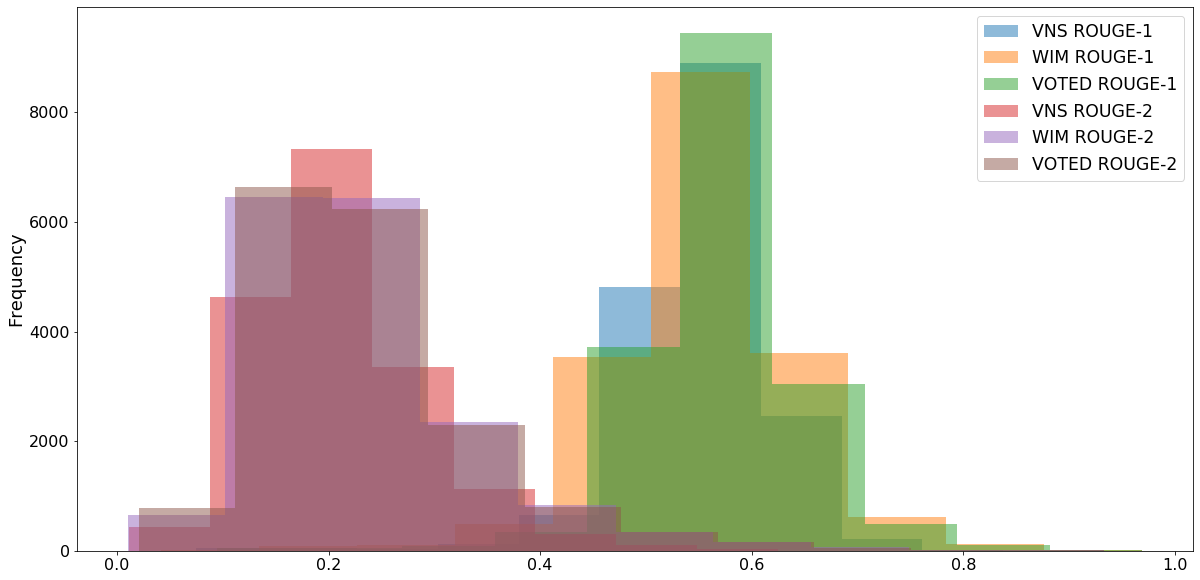

In [44]:
ds_merged['best_rouge1_vns'].plot.hist(figsize=(20, 10), alpha=0.5)
ds_merged['best_rouge1_wih'].plot.hist(figsize=(20, 10), alpha=0.5)
ds_merged['voted_r1'].plot.hist(figsize=(20, 10), alpha=0.5)
ds_merged['best_rouge2_vns'].plot.hist(figsize=(20, 10), alpha=0.5)
ds_merged['best_rouge2_wih'].plot.hist(figsize=(20, 10), alpha=0.5)
ds_merged['voted_r2'].plot.hist(figsize=(20, 10), alpha=0.5)
plt.legend(['VNS ROUGE-1', 'WIM ROUGE-1', 'VOTED ROUGE-1', 'VNS ROUGE-2', 'WIM ROUGE-2', 'VOTED ROUGE-2'], fontsize='xx-large')
plt.ylabel('Frequency', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Make a sentences dataset from merged 

In [74]:
ds_merged.head()

,article_id,article_text,abstract_text,section_names,sections,len_text,len_abstract,sent_ext,word_ext,word_inf,best_rouge1_wih,best_rouge2_wih,best_summary_wih,best_summary_vns,best_rouge1_vns,best_rouge2_vns,voted_summary,voted_method,voted_r1,voted_r2
0,astro-ph0202198,[the study of supernovae ( sne ) has greatly a...,[large numbers of supernovae ( sne ) have been...,"[introduction, method, results, future prospec...",[[the study of supernovae ( sne ) has greatly ...,341,12,0.000000,0.897436,0.076004,0.484935,0.146763,"[once discovered , the study of a particular s...","[2001 ; miknaitis et al ., spectroscopic follo...",0.541667,0.167247,"[2001 ; miknaitis et al ., spectroscopic follo...",vns,0.541667,0.167247
1,0905.2691,[it is believed that solar magnetic fields are...,[we investigate the emergence of magnetic flux...,"[introduction, observations and data reduction...",[[it is believed that solar magnetic fields ar...,329,11,0.000000,0.884892,0.073258,0.629482,0.296000,[they move upward and emerge into the solar at...,"[* ) . outside of active regions ,, the obs...",0.533333,0.174442,[they move upward and emerge into the solar at...,wih,0.629482,0.296000
2,1305.7010,[the origin - destination ( od ) matrix is imp...,[the estimation of the number of passengers wi...,"[introduction, the passenger model, the observ...",[[the origin - destination ( od ) matrix is im...,225,10,0.000000,0.740157,0.074367,0.454395,0.123128,[+ when the information is not available ( for...,[the origin - destination ( od ) matrix is imp...,0.502901,0.128155,[the origin - destination ( od ) matrix is imp...,vns,0.502901,0.128155
3,1402.0371,[multiscale dynamics is present in many phenom...,[the classical structure - function ( sf ) met...,"[introduction, detrending analysis and detrend...",[[multiscale dynamics is present in many pheno...,216,15,0.066667,0.949045,0.171659,0.767442,0.556667,[a detrended structure - function ( dsf ) meth...,[the corresponding scaling exponent @xmath0 is...,0.558214,0.272000,[a detrended structure - function ( dsf ) meth...,wih,0.767442,0.556667
4,1701.00774,[the @xmath3-transformation has been extensive...,"[given a real number @xmath0 , we study the as...","[introduction, coded negative beta-shift, lap ...",[[the @xmath3-transformation has been extensiv...,353,11,0.000000,0.867925,0.059547,0.541176,0.236407,"[thus , the previous proposition allows us to ...",[one endows @xmath78 ( or @xmath79 ) with the ...,0.518201,0.180645,"[thus , the previous proposition allows us to ...",wih,0.541176,0.236407


In [75]:
vns_labels = []
wih_labels = []
voted_labels = []
sentences = []
art_ids = []

for i in tqdm(range(ds_merged.shape[0])):
    vns_labels.append([1 if s in ds_merged.best_summary_vns[i] else 0 for s in ds_merged.article_text.values[i]])
    wih_labels.append([1 if s in ds_merged.best_summary_wih[i] else 0 for s in ds_merged.article_text.values[i]])
    voted_labels.append([1 if s in ds_merged.voted_summary[i] else 0 for s in ds_merged.article_text.values[i]])
    sentences.append(ds_merged.article_text.values[i])
    art_ids.append([ds_merged.article_id[i] for s in ds_merged.article_text.values[i]])
    

In [76]:
from itertools import chain
vns_labels = list(chain(*vns_labels))
wih_labels = list(chain(*wih_labels))
voted_labels = list(chain(*voted_labels))
sentences = list(chain(*sentences))
art_ids = list(chain(*art_ids))
print(len(vns_labels), len(wih_labels), len(voted_labels), len(sentences), len(art_ids))

4566447 4566447 4566447 4566447 4566447


In [77]:
ds_sents_merged = pd.DataFrame()
ds_sents_merged['art_ids'] = art_ids
ds_sents_merged['sentences'] = sentences
ds_sents_merged['wih_labels'] = wih_labels
ds_sents_merged['vns_labels'] = vns_labels
ds_sents_merged['voted_labels'] = voted_labels
ds_sents_merged.head()

,art_ids,sentences,wih_labels,vns_labels,voted_labels
0,astro-ph0202198,the study of supernovae ( sne ) has greatly ad...,0,0,0
1,astro-ph0202198,intensive and highly automated monitoring of n...,0,0,0
2,astro-ph0202198,1996 ; treffers et al .,0,0,0
3,astro-ph0202198,1997 ; filippenko et al .,0,0,0
4,astro-ph0202198,"2001 ; dimai 2001 ; qiu & hu 2001 ) , wide - f...",0,0,0


In [78]:
print(sum(ds_sents_merged.wih_labels.values), sum(ds_sents_merged.vns_labels.values), sum(ds_sents_merged.voted_labels.values))

120216 265497 196087


In [79]:
#Calculate correlations between labels produced by wih greedy algorithm and vns
ds_sents_merged.corr()

,wih_labels,vns_labels,voted_labels
wih_labels,1.000000,0.123504,0.474760
vns_labels,0.123504,1.000000,0.633703
voted_labels,0.474760,0.633703,1.000000


In [80]:
#save the obtained dataset
save_obj(ds_sents_merged, 'ds_sents_merged')
